In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
from omegaconf import OmegaConf

gpu_config = {
    "seed": 42,
    "device": "cuda",
}

gpu_config = OmegaConf.create(gpu_config)

In [4]:
import torch
import numpy as np

torch.manual_seed(gpu_config.seed)
np.random.seed(gpu_config.seed)

if torch.cuda.is_available and 'cuda' in gpu_config.device:
    torch.cuda.manual_seed(gpu_config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

os.environ['PYTHONASHSEED'] = str(gpu_config.seed)

In [5]:
dataloader_cfg = {
    "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
    "ratio_val": 0.1,
    "random_val": False,
    "extend_data": True,
    "sample_duration": 2.0,
    "remove_segments_inactive": False,
    "p_drop": 0.0,
    "p_insert": 0.0,
    "jitter_sigma": 0.0,
    "dtype": "float32",
    "dt": 4e-3,
}

dataloader_cfg = OmegaConf.create(dataloader_cfg)

In [6]:
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dtype = getattr(torch, dataloader_cfg.dtype)
dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [7]:
monkey_name = "indy"
monkey_files = {
    "indy": {
        "session01": "indy_20160622_01.mat",
        "session02": "indy_20160624_03.mat",
    }
}

In [8]:
filename = list(monkey_files[monkey_name].values())
filename

['indy_20160622_01.mat', 'indy_20160624_03.mat']

In [9]:
train_data, val_data, test_data = dataloader.get_multiple_sessions_data(filename)

[2025-06-29 12:46:49] [INFO] [efficient_rsnn_bmi.base.dataloader] - [1/2] Loading session: indy_20160622_01.mat


Loading indy_20160622_01.mat
[2025-06-29 12:46:57] [INFO] [efficient_rsnn_bmi.base.dataloader] - Extending data...
[2025-06-29 12:47:21] [INFO] [efficient_rsnn_bmi.base.dataloader] - [2/2] Loading session: indy_20160624_03.mat
Loading indy_20160624_03.mat
[2025-06-29 12:47:23] [INFO] [efficient_rsnn_bmi.base.dataloader] - Extending data...


In [10]:
nb_time_steps = int(dataloader_cfg.sample_duration / dataloader_cfg.dt)
nb_outputs = train_data[0][1].shape[1]
nb_inputs = train_data[0][0].shape[1]

print(f"Time Steps: {nb_time_steps}")
print(f"Input Channels: {nb_inputs}")
print(f"Output Channels: {nb_outputs}")

Time Steps: 500
Input Channels: 96
Output Channels: 2


In [11]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}
training_config = OmegaConf.create(training_config)

In [12]:
device = "cuda:0"

In [13]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn_interpolate_out import InterpolateOutRecurrentSpikingModel
# from efficient_rsnn_bmi.experiments.models.rsnn.rsnn_interpolate import InterpolateRecurrentSpikingModel

model = InterpolateOutRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
    n_keys=2
)

In [14]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True,
        "key_step": 8,
    }
}

model_config = OmegaConf.create(model_config)

In [15]:
import stork

activation_function = stork.activations.CustomSpike

if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

In [16]:
regs = []

regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)

regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)

regs.append(regLB)
regs.append(regUB)

In [17]:
from efficient_rsnn_bmi.core.dataloader import compute_input_firing_rates

mean1, mean2 = compute_input_firing_rates(train_data, dataloader_cfg)

In [18]:
initializers_config = {
    "initializer": {
        "compute_nu": True,
        "sigma_u": 0.5,
        "nu": 20,
        "alpha": 0.9,
        "kaiming_gain": 1.0
    }
}

initializers_config = OmegaConf.create(initializers_config)

In [19]:
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer
)

hidden_init = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=initializers_config.initializer.sigma_u,
    nu=mean1,
    timestep=dataloader_cfg.dt,
    alpha=initializers_config.initializer.alpha,
    dtype=dtype,
)

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [20]:
# from stork.nodes import InputGroup
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.interpolation.inputs import InterpolationInputGroup
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

input_group = model.add_group(
    InterpolationInputGroup(
        shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)
current_src_grp = input_group

In [21]:
current_src_grp = input_group
for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales,
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse,
        },
        connection_class=Connection,
        connection_kwargs={}
    )

    current_src_grp = hidden_layer.output_group
    print(current_src_grp)

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_data is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    print("Readout group shape: ", readout_group.shape)
    print("Current source group shape: ", current_src_grp.shape)
    print(current_src_grp, readout_group)
    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)
Readout group shape:  (2,)
Current source group shape:  (64,)
CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
) CustomReadoutGroup()


In [22]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError

loss_class = RootMeanSquareError()
# Mask Early Timestep later

from stork.optimizers import SMORMS3

opt_kwargs = {
    "lr": 2e-3
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

# Make sure this later (Worker Init Seeding)

import numpy as np
import random

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

from stork.generators import StandardGenerator

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

In [23]:
model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.dt,
)

In [24]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InterpolationInputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 1/4 [00:00<00:02,  1.00it/s]

Enter interpolation
Exit interpolation


Evaluating:  50%|█████     | 2/4 [00:01<00:01,  1.78it/s]

Enter interpolation
Exit interpolation


Evaluating:  75%|███████▌  | 3/4 [00:01<00:00,  2.41it/s]

Enter interpolation
Exit interpolation


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

Enter interpolation
Exit interpolation
Evaluation Score: [ 0.28396481  0.00134143  0.0205     -0.20975    -0.09475   ]



/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:264: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


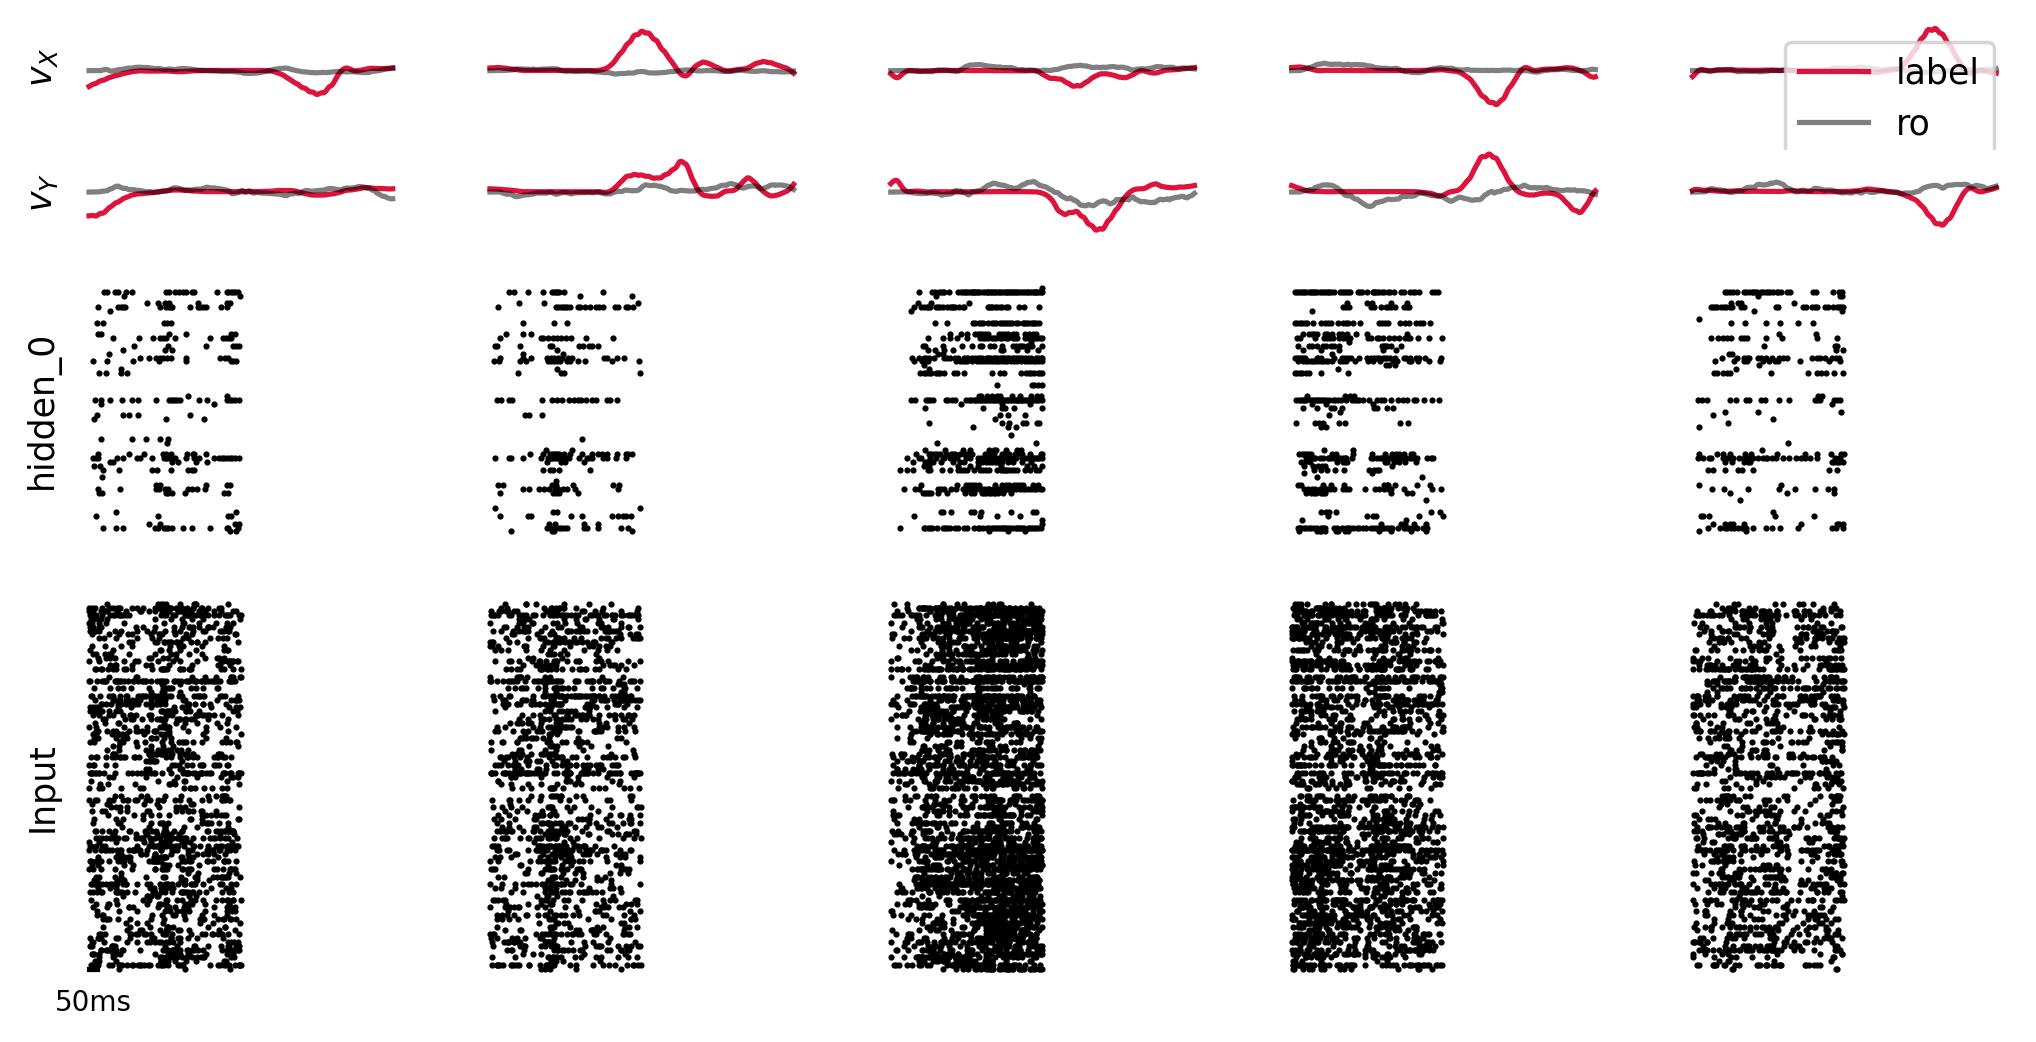

In [25]:
from datetime import datetime
from pathlib import Path
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]


Evaluation Score: [ 0.28397053  0.00139403  0.0205     -0.21       -0.09475   ]


/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:264: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


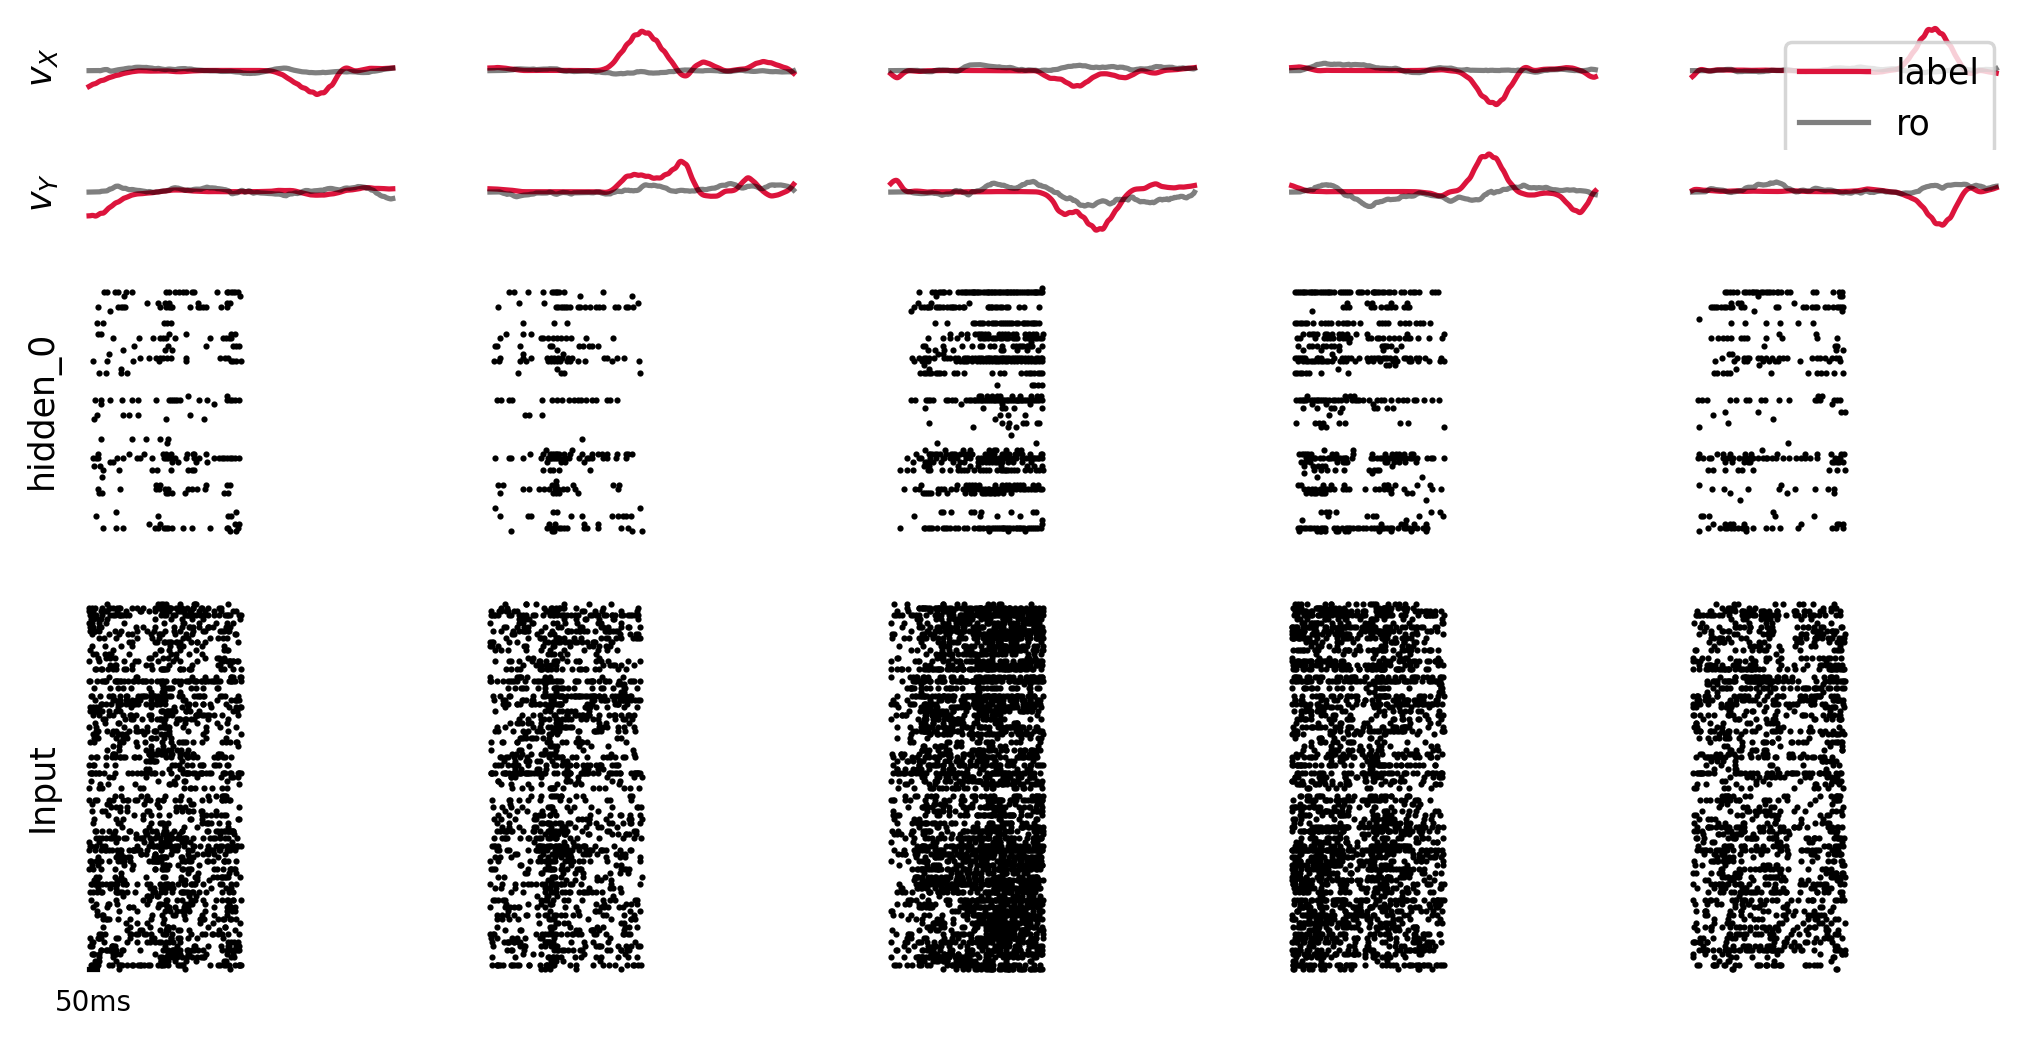

In [27]:
from datetime import datetime
from pathlib import Path
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

In [ ]:
from datetime import datetime
from pathlib import Path

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

fig, ax = model.fit_validate(
    model,
    val_data,
    best_model_path= output_dir / f"pretraining/baseline_{monkey_name}/best_model.pth",
    nb_epochs=5,
    early_stop=True
)

Early stopping enabled with patience of 10. Best model will be saved to 'outputs/baseline/2025-06-29_11-57-53/pretraining/baseline_indy/best_model.pth'


TypeError: object of type 'InterpolateRecurrentSpikingModel' has no len()